In [ ]:
import tensorflow as tf #importowanie wymaganych bibliotek
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential, load_model
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [20]:
data = pd.read_csv('zmienne/integrated_data.csv')#wczytanie pliku


print("Dane przed usunięciem NaN:",len(data), "liczba kolumn:",len(data.columns))#wyświetlenie liczby rekordów i kolumn
data = data.drop('Wolumen_ftse250_d', 1)#usunięcie kolumny z pustymi wartościami
data['Zamkniecie'] = data['Zamkniecie'].shift(-1)#przesunięcie kolumny prognowanej o jeden indeks - prognoza ma być na nastęną sesję - można zmienić i prognozować na większą liczbę sesji do przodu
data = data.dropna()#usunięcie danych Not a number
print("Dane po usunięciu NaN:",len(data), "liczba kolumn:",len(data.columns))


Dane przed usunięciem NaN: 2458 liczba kolumn: 80
Dane po usunięciu NaN: 2412 liczba kolumn: 79


In [21]:
print(data.head())#wyświetlenie nagłówka tabeli, aby sprawdzić poprawność poprzednich operacji na danych

         Data  Otwarcie  Najwyzszy  Najnizszy  Zamkniecie  Wolumen  \
0  2010-09-22    248.40     248.59     246.99      246.40     1861   
1  2010-09-23    249.35     250.48     244.54      248.78     4552   
2  2010-09-24    246.61     249.25     245.34      248.78    12244   
3  2010-09-27    250.19     250.38     248.78      246.33    14712   
4  2010-09-28    247.27     248.12     246.33      247.37     1416   

   Otwarcie_gbpeur_d  Najwyzszy_gbpeur_d  Najnizszy_gbpeur_d  \
0             1.1777              1.1816              1.1658   
1             1.1681              1.1802              1.1674   
2             1.1780              1.1789              1.1700   
3             1.1736              1.1777              1.1731   
4             1.1763              1.1811              1.1622   

   Zamkniecie_gbpeur_d  ...  Otwarcie_btcusd_d  Najwyzszy_btcusd_d  \
0               1.1679  ...            0.06265             0.06265   
1               1.1778  ...            0.06220        

In [22]:
data.describe()

,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen,Otwarcie_gbpeur_d,Najwyzszy_gbpeur_d,Najnizszy_gbpeur_d,Zamkniecie_gbpeur_d,Otwarcie_eurpln_d,...,Otwarcie_btcusd_d,Najwyzszy_btcusd_d,Najnizszy_btcusd_d,Zamkniecie_btcusd_d,Otwarcie_hg,Najwyzszy_hg,Najnizszy_hg,Zamkniecie_hg,Wolumen_hg,LOP
count,2412.000000,2412.000000,2412.000000,2412.000000,2412.000000,2412.000000,2412.000000,2412.000000,2412.000000,2412.000000,...,2412.000000,2412.000000,2412.000000,2412.000000,2412.000000,2412.000000,2412.000000,2412.000000,2412.000000,2412.000000
mean,253.657695,255.069486,251.377794,253.042682,2087.882670,1.195197,1.199729,1.190478,1.195165,4.235874,...,2803.187732,2882.482153,2713.389697,2804.147099,301.777405,304.754859,298.654573,301.772753,81168.174544,197265.720564
std,26.572035,26.450733,26.957590,26.765565,4674.589263,0.080158,0.080725,0.079533,0.080139,0.135145,...,3899.077030,4014.859102,3760.322581,3896.165811,57.411930,57.972997,56.725018,57.418161,36432.139890,52914.309719
min,176.000000,182.600000,172.500000,175.100000,3.000000,1.064740,1.081300,1.052560,1.064820,3.836900,...,0.061110,0.061910,0.060810,0.061300,195.400000,198.000000,193.700000,194.800000,17772.000000,112315.000000
25%,230.630000,231.915000,228.000000,229.987500,329.750000,1.136763,1.141285,1.132300,1.136805,4.164200,...,88.752500,94.475000,80.065000,88.829500,262.375000,265.037500,260.000000,262.575000,53902.000000,154741.750000
50%,261.455000,262.800000,259.305000,260.755000,754.500000,1.172100,1.176640,1.167540,1.171990,4.239620,...,509.035000,521.675000,485.770000,509.540000,297.825000,300.425000,295.175000,297.625000,72835.500000,177656.500000
75%,272.762500,274.000000,270.730000,272.112500,1961.250000,1.238725,1.243125,1.235125,1.238985,4.309600,...,5812.277500,6025.040000,5614.037500,5838.670000,333.450000,336.900000,329.900000,333.325000,101076.000000,244748.500000
max,314.050000,316.200000,312.900000,314.200000,100473.000000,1.440500,1.441700,1.433200,1.439100,4.631620,...,19380.000000,19455.000000,18083.000000,18762.000000,463.100000,464.500000,454.350000,463.100000,260330.000000,337907.000000


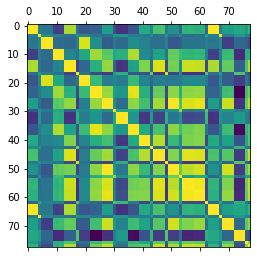

In [23]:
plt.matshow(data.corr())

In [24]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);

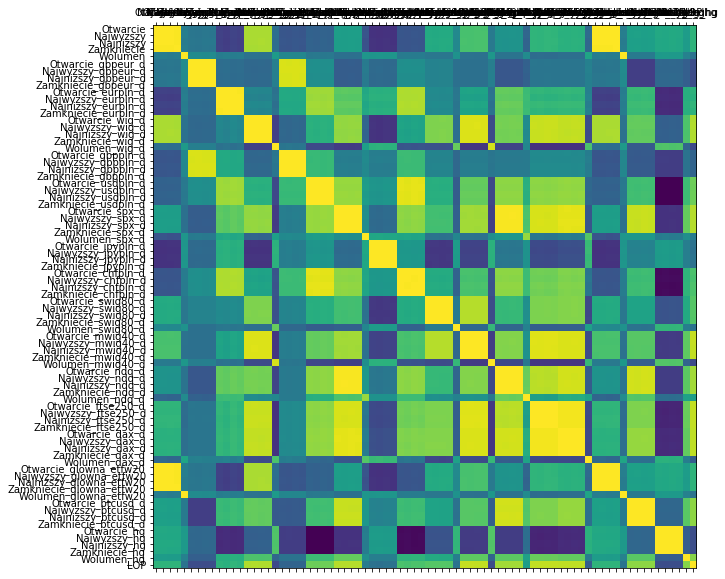

In [27]:
plot_corr(data,79)

In [28]:
corr = data.corr()
corr.style.background_gradient()

In [29]:
corr.to_csv('correlations.csv')

In [30]:
from sklearn.preprocessing import MinMaxScaler

class BatchedData():
    from sklearn.preprocessing import MinMaxScaler

    def __init__(self,data,num_days,scaler=MinMaxScaler()):
        self.scaler = scaler
        self.data = data
        self.num_days = num_days
        
        #ogólnie zmienne z literą "X" dotyczą zbioru wejściowego, natomiast z literą "Y" dotyczą zbioru wyjściowego
        
        self.X = self.scaler.fit_transform(self.data.drop(columns=['Data','Zamkniecie']))#normalizacja danych i usunięcie kolumn, które nie mają być danymi wejściowymi
        self.y = self.data['Zamkniecie'].values/np.max(self.data['Zamkniecie'])#wartość kolumny "Zamknięcie" jest prognozowana na wyjściu sieci
        
        self.rng = np.random.randint(1,len(self.data)-self.num_days)#losowe wybieranie rekordów do zbiorów testowych i uczących
        self.x_batch = self.X[self.rng:self.rng+self.num_days,:]
        self.y_batch = self.y[self.rng-1]

    def nextBatch(self):
        rng = np.random.randint(1,len(self.data)-self.num_days)
        
        while(True):
            rng = np.random.randint(1,len(self.data)-self.num_days)
            
            if rng != self.rng:
                self.rng = rng
                break
                
        self.x_batch = self.X[self.rng:self.rng+self.num_days,:].reshape([self.num_days,self.X.shape[1]])
        self.y_batch = self.y[self.rng-1]
        
    def createDataset(self):
        train_range = int(len(self.data) * 0.67)# zbiór uczący
        test_range = int(len(self.data) * 0.33)#zbiór testowy
        
        self.X_train = np.zeros([train_range,num_days,self.X.shape[1]])
        self.Y_train = np.zeros([train_range])

        for i in range(train_range):
            self.nextBatch()
            self.X_train[i,:,:] = self.x_batch
            self.Y_train[i] = self.y_batch

        self.X_test = np.zeros([test_range,num_days,self.X.shape[1]])
        self.Y_test = np.zeros([test_range])

        for i in range(test_range):
            self.nextBatch()
            self.X_test[i,:,:] = self.x_batch
            self.Y_test[i] = self.y_batch

In [31]:
num_days = 7 #liczba dni historycznych
batched_data = BatchedData(data,num_days)
batched_data.createDataset()#utworzony jest zbiór z danymi historycznymi

len(np.unique(batched_data.Y_train))

885

In [32]:
data_size = int(batched_data.x_batch.shape[1])
#print(data_size)
#tworzenie modelu
model = Sequential()

model.add(LSTM(units=77,activation='relu',input_shape=[num_days,data_size],return_sequences=True))
#tworzenie warstwy LSTM, podajemy liczbę neuronow, rodzaj funkcji aktywacji, liczbę historycznych notowań, rozmiar danych, zwracana jest sekwencja danych taka, jaka jest liczba historycznych notowań
#model.add(LSTM(units=100,activation='relu',return_sequences=True))
#model.add(LSTM(units=74,activation='relu',return_sequences=True))
model.add(Dropout(rate=0.5))

#model.add(LSTM(units=56,activation='softmax',return_sequences=True))
#model.add(LSTM(units=42,activation='softmax',return_sequences=True))
model.add(LSTM(units=37,activation='softmax',return_sequences=True))
model.add(Dropout(rate=0.5))

model.add(LSTM(units=24,activation='relu',return_sequences=True))
model.add(LSTM(units=12,activation='relu',return_sequences=True))
model.add(Dropout(rate=0.3))

model.add(LSTM(units=6,activation='sigmoid',return_sequences=True))
model.add(Flatten())
model.add(Dense(units=1,activation='sigmoid'))


In [33]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])#kompilacja modelu, funkcja oceny i metryka to błąd średniokwadratowy

In [41]:
epochs = 60 #liczba epok uczących
batch=32
#uczenie modelu, podajemy jako parametry dane ze zbioru uczącego (wejście i wyjćie) i dane ze zbioru testowego (wejście i wyjćie)

history = model.fit(batched_data.X_train,batched_data.Y_train,
                    validation_data=(batched_data.X_test,batched_data.Y_test),
                    epochs=epochs,
                    batch_size=batch)

Train on 1616 samples, validate on 795 samples
Epoch 1/60
1616/1616 [==============================] - 1s 508us/sample - loss: 1.3683e-04 - mse: 1.3683e-04 - val_loss: 4.6775e-05 - val_mse: 4.6775e-05
Epoch 2/60
1616/1616 [==============================] - 1s 502us/sample - loss: 1.2323e-04 - mse: 1.2323e-04 - val_loss: 7.4797e-05 - val_mse: 7.4797e-05
Epoch 3/60
1616/1616 [==============================] - 1s 498us/sample - loss: 1.3082e-04 - mse: 1.3082e-04 - val_loss: 4.0905e-05 - val_mse: 4.0905e-05
Epoch 4/60
1616/1616 [==============================] - 1s 491us/sample - loss: 1.1797e-04 - mse: 1.1797e-04 - val_loss: 3.8639e-05 - val_mse: 3.8639e-05
Epoch 5/60
1616/1616 [==============================] - 1s 505us/sample - loss: 1.2806e-04 - mse: 1.2806e-04 - val_loss: 3.5145e-05 - val_mse: 3.5145e-05
Epoch 6/60
1616/1616 [==============================] - 1s 508us/sample - loss: 1.0871e-04 - mse: 1.0871e-04 - val_loss: 5.7463e-05 - val_mse: 5.7463e-05
Epoch 7/60
1616/1616 [=======

1616/1616 [==============================] - 1s 490us/sample - loss: 9.7414e-05 - mse: 9.7414e-05 - val_loss: 3.5493e-05 - val_mse: 3.5493e-05
Epoch 54/60
1616/1616 [==============================] - 1s 487us/sample - loss: 1.0263e-04 - mse: 1.0263e-04 - val_loss: 3.0127e-05 - val_mse: 3.0127e-05
Epoch 55/60
1616/1616 [==============================] - 1s 486us/sample - loss: 9.5729e-05 - mse: 9.5729e-05 - val_loss: 3.3952e-05 - val_mse: 3.3952e-05
Epoch 56/60
1616/1616 [==============================] - 1s 497us/sample - loss: 9.4202e-05 - mse: 9.4202e-05 - val_loss: 4.1436e-05 - val_mse: 4.1436e-05
Epoch 57/60
1616/1616 [==============================] - 1s 508us/sample - loss: 9.8956e-05 - mse: 9.8956e-05 - val_loss: 3.2428e-05 - val_mse: 3.2428e-05
Epoch 58/60
1616/1616 [==============================] - 1s 502us/sample - loss: 8.8712e-05 - mse: 8.8712e-05 - val_loss: 3.5660e-05 - val_mse: 3.5660e-05
Epoch 59/60
1616/1616 [==============================] - 1s 493us/sample - loss: 9

In [42]:
print(history.history['val_loss'])

[4.677534495197008e-05, 7.479697898198315e-05, 4.090482129095966e-05, 3.863905841635127e-05, 3.514477416416103e-05, 5.7463191650348784e-05, 5.1104331859673006e-05, 6.822146621383376e-05, 5.2235838913200596e-05, 4.382999836278306e-05, 8.095616389907246e-05, 3.9343434366186695e-05, 4.119928632445528e-05, 7.128018477024458e-05, 4.114856666727167e-05, 3.7174128051704447e-05, 3.364172240802667e-05, 3.4378258104245e-05, 4.354487508914284e-05, 5.8088122881050574e-05, 3.404776020857444e-05, 3.463461323677483e-05, 4.3582235285045825e-05, 3.620371054188032e-05, 4.2866175032752336e-05, 4.332906960285673e-05, 3.3449998577366986e-05, 4.2196817402036e-05, 7.968460185506012e-05, 5.144340447139188e-05, 4.521663260057498e-05, 3.954965657887339e-05, 3.79670782902669e-05, 4.899775384780336e-05, 6.594125669886675e-05, 4.335897056251887e-05, 3.9953163622896064e-05, 5.144636850432879e-05, 4.520895295086721e-05, 5.010565306841976e-05, 3.14591297419096e-05, 3.469177232923443e-05, 3.8382324652596953e-05, 3.604

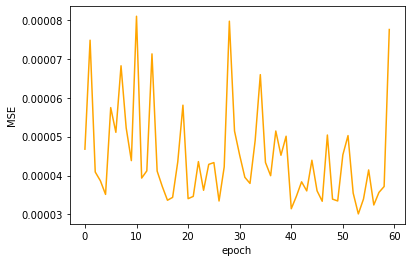

In [43]:
plt.plot(history.history['val_loss'],color='orange')#wykres procesu uczenia się - wyniki danych testowych
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.show()

In [44]:
Y_pred=model.predict(batched_data.X_test)#dokonujemy predykcji z wykorzystaniem nauczonego modelu


In [45]:
for i in range(len(batched_data.Y_test)):
            print(Y_pred[i,0],'\t',batched_data.Y_test[i]) #wyświetlenie wartości prognozowanych i faktycznych


0.6824222 	 0.6945894334818588
0.72651285 	 0.7333863781031191
0.7123296 	 0.7224697644812221
0.9449858 	 0.9463717377466583
0.6809322 	 0.6900381922342458
0.6700588 	 0.67982176957352
0.82414174 	 0.8297262889879058
0.83279306 	 0.8392743475493316
0.7894994 	 0.8020369191597708
0.8527179 	 0.8511457670273711
0.675222 	 0.6810948440483768
0.8324387 	 0.833831954169319
0.912279 	 0.9096117122851688
0.7105265 	 0.7161043921069383
0.8600719 	 0.8687141947803947
0.8894964 	 0.9005410566518142
0.64154226 	 0.6586569064290261
0.82833076 	 0.8313176320814768
0.6931539 	 0.7030553787396563
0.6478488 	 0.647262889879058
0.72184175 	 0.7311266709102483
0.8357815 	 0.8416295353278167
0.74388164 	 0.7657542966263526
0.6483569 	 0.6584977721196691
0.8634772 	 0.8660725652450669
0.9324011 	 0.9299809038828771
0.8912642 	 0.901973265436028
0.8580003 	 0.8586887332908976
0.8420963 	 0.8397835773392744
0.7102756 	 0.7178548695098664
0.8798134 	 0.8911521323997454
0.7660973 	 0.7749840865690644
0.848096

0.6294279 	 0.6365372374283896
0.8059865 	 0.8165181413112668
0.87134135 	 0.875875238701464
0.8950946 	 0.8992679821769575
0.65591884 	 0.6677275620623807
0.8339139 	 0.8434118395926162
0.87378967 	 0.8781031190324634
0.8679771 	 0.8755569700827499
0.8329103 	 0.8370464672183323
0.6401075 	 0.6479949077021006
0.90688956 	 0.9161043921069382
0.83145386 	 0.8392425206874602
0.79325324 	 0.8020369191597708
0.7082779 	 0.7135582431572247
0.9418952 	 0.9437619350732017
0.6799002 	 0.6874602164226608
0.7015074 	 0.704774029280713
0.91921407 	 0.9245703373647358
0.8607848 	 0.8596435391470402
0.867266 	 0.8706874602164226
0.6766282 	 0.6935073201782305
0.83848464 	 0.8478676002546148
0.72284365 	 0.728835136855506
0.69655174 	 0.6982813494589434
0.8166243 	 0.8147676639083387
0.8572014 	 0.8653723742838956
0.83439744 	 0.8434118395926162
0.82166696 	 0.828676002546149
0.83512735 	 0.8378421387651178
0.6908612 	 0.7001909611712286
0.69348454 	 0.7052832590706556
0.8896572 	 0.897199236155315
